<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr%5Cmodely_RP%5CR_afrika.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=ff35ff6478599dc54244e8b24432e6bf4bb055e38d922c84940b373ceb7ea707
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad

from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

dataw = pd.read_csv("/content/drive/My Drive/data/dataw.csv")


tilyvoafar = tilyvoa.groupby('Faritra')
tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

datawcount = dataw.groupby('countriesAndTerritories')

datawke = datawcount.get_group('Kenya')
datawke.set_index('dateRep', inplace=True)
datawke.index = pd.to_datetime(datawke.index, dayfirst =True)

datawcod = datawcount.get_group('Democratic_Republic_of_the_Congo')
datawcod.set_index('dateRep', inplace=True)
datawcod.index = pd.to_datetime(datawcod.index, dayfirst=True)

datawsa = datawcount.get_group('South_Africa')
datawsa.set_index('dateRep', inplace=True)
datawsa.index = pd.to_datetime(datawsa.index, dayfirst=True)

dataweg = datawcount.get_group('Egypt')
dataweg.set_index('dateRep', inplace=True)
dataweg.index = pd.to_datetime(dataweg.index, dayfirst=True)

datawng = datawcount.get_group('Nigeria')
datawng.set_index('dateRep', inplace=True)
datawng.index = pd.to_datetime(datawng.index, dayfirst=True)

datawmdg = datawcount.get_group('Madagascar')
datawmdg.set_index('dateRep', inplace=True)
datawmdg.index = pd.to_datetime(datawmdg.index, dayfirst=True)

path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Madagasikara

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


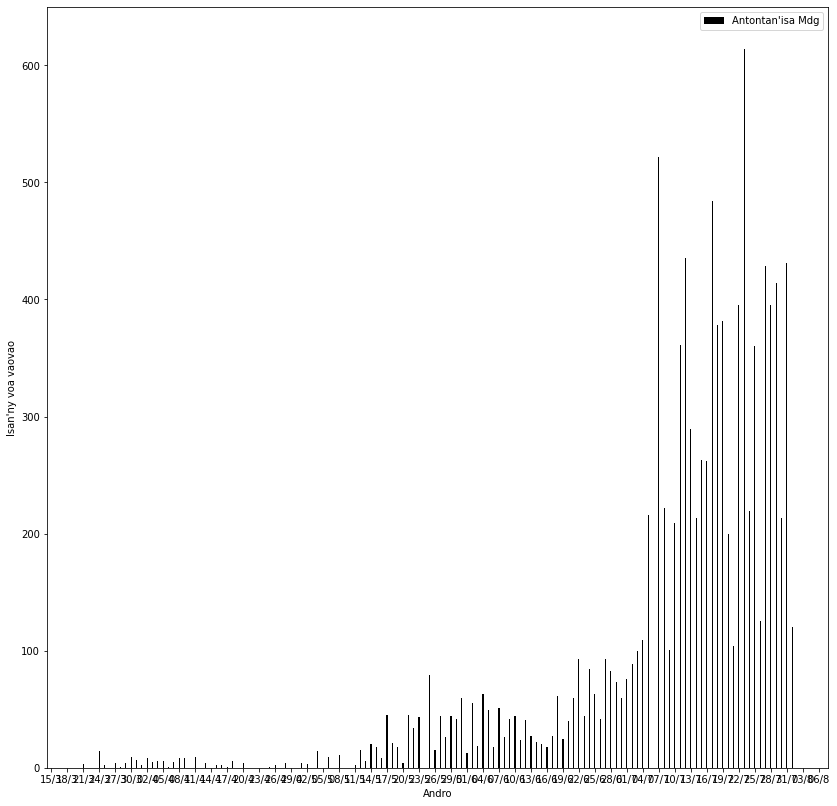

In [5]:
fig, ax = plt.subplots(figsize=(14, 14))

ax.bar(datawmdg.index, datawmdg['cases'], width = 0.2, color='black',label="Antontan'isa Mdg")


ax.set(xlabel ='Andro', ylabel = "Isan'ny voa vaovao")

date_form = DateFormatter("%d/%-m")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.legend(loc= 'best')

plt.ylim(0,650)
plt.savefig(path_to_save+'voavaomdgzao.eps')
plt.savefig(path_to_save+'voavaomdgzao.png')

plt.show()

In [29]:
# Voa vaovao (observed incidence)
Ivao = datawmdg['cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,1)
daty_data_mifar = datetime.date(2020,8,1)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 7, 14)), (inf, datetime.date(2020, 7, 13)), (inf, datetime.date(2020, 7, 12)), (inf, datetime.date(2020, 7, 11)), (inf, datetime.date(2020, 7, 10)), (inf, datetime.date(2020, 7, 9)), (inf, datetime.date(2020, 7, 8)), (inf, datetime.date(2020, 7, 7)), (inf, datetime.date(2020, 7, 6)), (inf, datetime.date(2020, 7, 5)), (inf, datetime.date(2020, 7, 4)), (inf, datetime.date(2020, 7, 3)), (inf, datetime.date(2020, 7, 2)), (inf, datetime.date(2020, 7, 1)), (inf, datetime.date(2020, 6, 30)), (inf, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (626.7442844137327, datetime.date(2020, 6, 26)), (643.8241660716423, datetime.date(2020, 6, 25)), (487.8113753316386, datetime.date(2020, 6, 24)), (332.58271143757975, datetime.date(2020, 6, 23))]
Prt91 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.433032044222724e-273, 2.4587669063479024e-280, 1

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


APEk1 = [2493.344594030311, inf, inf, inf, inf, inf, inf]
APEk2 = [3.2928963347349836, 7.171279694992251, 43.79284078799698, 97.31383212040049, 182.28081215250754, 309.4949238500569, 618.0797898646933]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [2496.637490365046, inf, inf, inf, inf, inf, inf]
APE = [2496.637490365046, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [30]:
kk=2
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


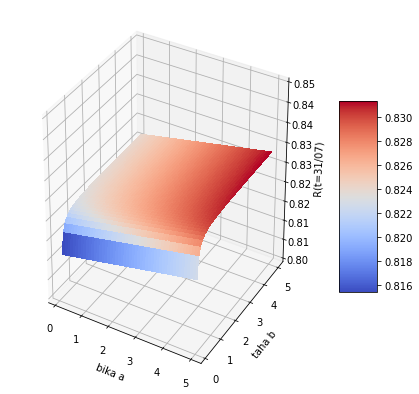

In [31]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.8, 0.85)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=31/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt317_mdg.eps')

plt.show()

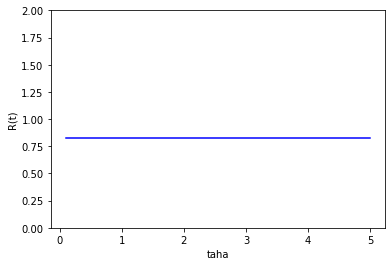

taha* = 1
R(t= 2020-08-01 ) = 0.8241335363989531 = bika*


In [12]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [32]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,7,13)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-08-01 : 0.3572107710929749
Salan'isa R hoan'ny 2020-07-13 : 1.8891642430004936
Kartily @ 75% R hoan'ny 2020-07-13 : 1.935974018844009
Kartily @ 25% R hoan'ny 2020-07-13 : 1.841408868886875
Salan'isa R hoan'ny 2020-08-01 : 0.8241169986994941
Kartily @ 75% R hoan'ny 2020-08-01 : 0.8475005771404881
Kartily @ 25% R hoan'ny 2020-08-01 : 0.8001908153091537


In [38]:
rt_mdg_lst = []

for i in range(62):
  t = datetime.date(2020,8,1) - datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  rt_mdg_lst.append((t,Rt_salan(t)))

rt_mdg_lst

[(datetime.date(2020, 8, 1), array(0.824117)),
 (datetime.date(2020, 7, 31), array(0.97159885)),
 (datetime.date(2020, 7, 30), array(0.9593913)),
 (datetime.date(2020, 7, 29), array(1.25431777)),
 (datetime.date(2020, 7, 28), array(1.27631814)),
 (datetime.date(2020, 7, 27), array(0.85131396)),
 (datetime.date(2020, 7, 26), array(0.75094802)),
 (datetime.date(2020, 7, 25), array(0.92023976)),
 (datetime.date(2020, 7, 24), array(1.36081601)),
 (datetime.date(2020, 7, 23), array(1.65454187)),
 (datetime.date(2020, 7, 22), array(0.80444444)),
 (datetime.date(2020, 7, 21), array(0.49331443)),
 (datetime.date(2020, 7, 20), array(0.98512612)),
 (datetime.date(2020, 7, 19), array(1.36033714)),
 (datetime.date(2020, 7, 18), array(1.62094632)),
 (datetime.date(2020, 7, 17), array(1.45032636)),
 (datetime.date(2020, 7, 16), array(1.0545577)),
 (datetime.date(2020, 7, 15), array(1.0122593)),
 (datetime.date(2020, 7, 14), array(1.1684723)),
 (datetime.date(2020, 7, 13), array(1.88916424)),
 (datet

In [40]:
# MRC results 

r_mdg197 = 1.41
r_mdg177 = 1.45
r_mdg147 = 1.32
r_mdg137 = 1.3
r_mdg107 = 1.31
r_mdg067 = 1.49
r_mdg037 = 1.47
r_mdg027 = 1.42
r_mdg017 = 1.36
r_mdg276 = 0.65
r_mdg266 = 0.83
r_mdg256 = 1.89
r_mdg226 = 1.45
r_mdg206 = 1.26
r_mdg186 = 1.41
r_mdg166 = 1.33
r_mdg156 = 1.07
r_mdg146 = 0.9
r_mdg136 = 1.13
r_mdg086 = 1.92
r_mdg056 = 2.01
r_mdg036 = 2.02
r_mdg026 = 2.05
r_mdg016 = 2.1

In [41]:
elan_mdg197 = r_mdg197 - rt_mdg_lst[12][1]
elan_mdg177 = r_mdg177 - rt_mdg_lst[14][1]
elan_mdg147 = r_mdg147 - rt_mdg_lst[17][1]
elan_mdg137 = r_mdg137 - rt_mdg_lst[18][1]
elan_mdg107 = r_mdg107 - rt_mdg_lst[21][1]
elan_mdg067 = r_mdg067 - rt_mdg_lst[25][1]
elan_mdg037 = r_mdg037 - rt_mdg_lst[28][1]
elan_mdg027 = r_mdg027 - rt_mdg_lst[29][1]
elan_mdg017 = r_mdg017 - rt_mdg_lst[30][1]

elan_mdg276 = r_mdg276 - rt_mdg_lst[34][1]
elan_mdg266 = r_mdg266 - rt_mdg_lst[35][1]
elan_mdg256 = r_mdg256 - rt_mdg_lst[36][1]
elan_mdg226 = r_mdg226 - rt_mdg_lst[39][1]
elan_mdg206 = r_mdg206 - rt_mdg_lst[41][1]
elan_mdg186 = r_mdg186 - rt_mdg_lst[43][1]
elan_mdg166 = r_mdg166 - rt_mdg_lst[45][1]
elan_mdg156 = r_mdg156 - rt_mdg_lst[46][1]
elan_mdg146 = r_mdg146 - rt_mdg_lst[47][1]
elan_mdg136 = r_mdg136 - rt_mdg_lst[48][1]
elan_mdg086 = r_mdg086 - rt_mdg_lst[53][1]
elan_mdg056 = r_mdg056 - rt_mdg_lst[56][1]
elan_mdg036 = r_mdg036 - rt_mdg_lst[58][1]
elan_mdg026 = r_mdg026 - rt_mdg_lst[59][1]
elan_mdg016 = r_mdg016 - rt_mdg_lst[60][1]

print('197',elan_mdg197,rt_mdg_lst[12])
print('177',elan_mdg177,rt_mdg_lst[14])
print('147',elan_mdg147,rt_mdg_lst[17])
print('137',elan_mdg137,rt_mdg_lst[18])
print('107',elan_mdg107,rt_mdg_lst[21])
print('067',elan_mdg067,rt_mdg_lst[25])
print('037',elan_mdg037,rt_mdg_lst[28])
print('027',elan_mdg027,rt_mdg_lst[29])
print('017',elan_mdg017,rt_mdg_lst[30])

print('276',elan_mdg276,rt_mdg_lst[34])
print('266',elan_mdg266,rt_mdg_lst[35])
print('256',elan_mdg256,rt_mdg_lst[36])
print('226',elan_mdg226,rt_mdg_lst[39])
print('206',elan_mdg206,rt_mdg_lst[41])
print('186',elan_mdg186,rt_mdg_lst[43])
print('166',elan_mdg166,rt_mdg_lst[45])
print('156',elan_mdg156,rt_mdg_lst[46])
print('146',elan_mdg146,rt_mdg_lst[47])
print('136',elan_mdg136,rt_mdg_lst[48])
print('086',elan_mdg086,rt_mdg_lst[53])
print('056',elan_mdg056,rt_mdg_lst[56])
print('036',elan_mdg036,rt_mdg_lst[58])
print('026',elan_mdg026,rt_mdg_lst[59])
print('016',elan_mdg016,rt_mdg_lst[60])

197 0.42487387715551894 (datetime.date(2020, 7, 20), array(0.98512612))
177 -0.17094631508634395 (datetime.date(2020, 7, 18), array(1.62094632))
147 0.30774070375302753 (datetime.date(2020, 7, 15), array(1.0122593))
137 0.13152769752867455 (datetime.date(2020, 7, 14), array(1.1684723))
107 -0.49380454746483715 (datetime.date(2020, 7, 11), array(1.80380455))
067 -1.5161427794051827 (datetime.date(2020, 7, 7), array(3.00614278))
037 -0.01745798575349289 (datetime.date(2020, 7, 4), array(1.48745799))
027 0.028376446682897072 (datetime.date(2020, 7, 3), array(1.39162355))
017 0.11204602357343485 (datetime.date(2020, 7, 2), array(1.24795398))
276 -0.9567729676625673 (datetime.date(2020, 6, 28), array(1.60677297))
266 -0.47125553397499653 (datetime.date(2020, 6, 27), array(1.30125553))
256 0.8024618016825615 (datetime.date(2020, 6, 26), array(1.0875382))
226 -0.49950535783681227 (datetime.date(2020, 6, 23), array(1.94950536))
206 -0.3579034824011076 (datetime.date(2020, 6, 21), array(1.61790

In [ ]:
# Sampling except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Madagasikara")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt205206_mdg.eps')
plt.savefig(path_to_save+'Rt205206_mdg.png')
plt.show()

# Kenya

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


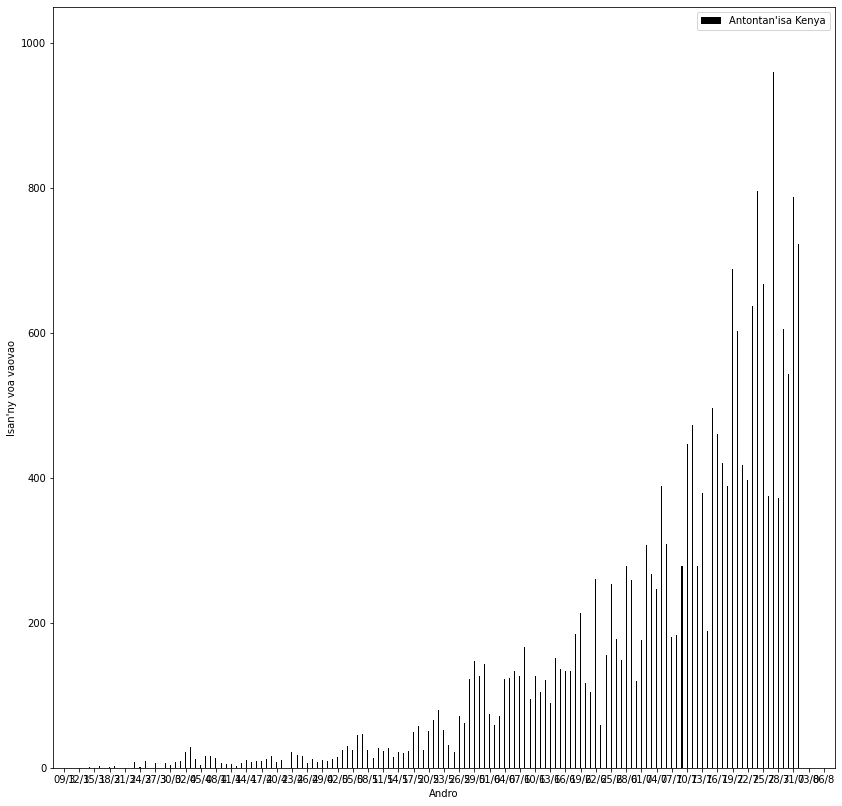

In [43]:
fig, ax = plt.subplots(figsize=(14, 14))

ax.bar(datawke.index, datawke['cases'], width = 0.2, color='black',label="Antontan'isa Kenya")


ax.set(xlabel ='Andro', ylabel = "Isan'ny voa vaovao")

date_form = DateFormatter("%d/%-m")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.legend(loc= 'best')

plt.ylim(0,1050)
plt.savefig(path_to_save+'voavaokezao.eps')
plt.savefig(path_to_save+'voavaokezao.png')

plt.show()

In [45]:
# Voa vaovao (observed incidence)
Ivao = datawke['cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,4,15)
daty_data_mifar = datetime.date(2020,8,1)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 7, 6)), (inf, datetime.date(2020, 7, 5)), (inf, datetime.date(2020, 7, 4)), (inf, datetime.date(2020, 7, 3)), (inf, datetime.date(2020, 7, 2)), (inf, datetime.date(2020, 7, 1)), (inf, datetime.date(2020, 6, 30)), (inf, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (inf, datetime.date(2020, 6, 26)), (inf, datetime.date(2020, 6, 25)), (inf, datetime.date(2020, 6, 24)), (inf, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15)), (inf, datetime.date(2020, 6, 14)), (inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6,

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


APEk1 = [5389.584492493537, inf, inf, inf, inf, inf, inf]
APEk2 = [3.0517153699813413, 8.008112334687413, 18.182724903583775, 51.71650309182418, 96.65697844338781, 190.77919592860752, 256.6125051716296]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [5392.636207863518, inf, inf, inf, inf, inf, inf]
APE = [5392.636207863518, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [46]:
kk=2
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


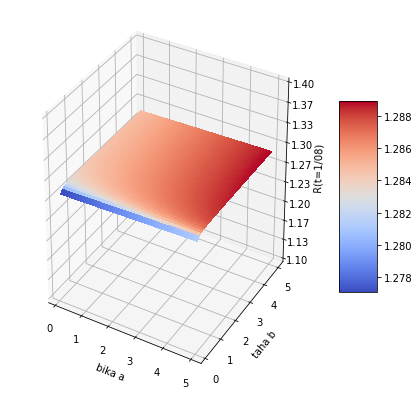

In [47]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.1, 1.4)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=1/08)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt18_ke.eps')

plt.show()

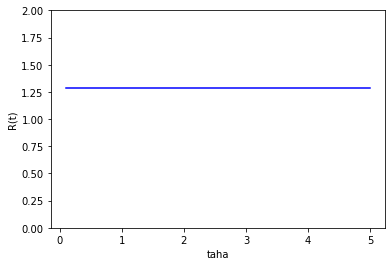

taha* = 1
R(t= 2020-08-01 ) = 1.2848976930967908 = bika*


In [48]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [49]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,14)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-08-01 : 1.2219741892888865
Salan'isa R hoan'ny 2020-06-14 : 1.0259258934377706
Kartily @ 75% R hoan'ny 2020-06-14 : 1.0695138989191364
Kartily @ 25% R hoan'ny 2020-06-14 : 0.9808044335304209
Salan'isa R hoan'ny 2020-08-01 : 1.2848976925316002
Kartily @ 75% R hoan'ny 2020-08-01 : 1.3070263972202805
Kartily @ 25% R hoan'ny 2020-08-01 : 1.2624602719264184


In [58]:
rt_ke_lst = []

for i in range(65):
  t = datetime.date(2020,8,1) - datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  ivao_ke = dIvao['cases'].loc[format_date(t)]
  rt_ke_lst.append((t,Rt_salan(t),ivao_ke))

rt_ke_lst

[(datetime.date(2020, 8, 1), array(1.28489769), 723),
 (datetime.date(2020, 7, 31), array(1.14187902), 788),
 (datetime.date(2020, 7, 30), array(0.9947331), 544),
 (datetime.date(2020, 7, 29), array(0.86340588), 606),
 (datetime.date(2020, 7, 28), array(1.21850454), 372),
 (datetime.date(2020, 7, 27), array(1.27106511), 960),
 (datetime.date(2020, 7, 26), array(1.0389842), 375),
 (datetime.date(2020, 7, 25), array(1.53954062), 667),
 (datetime.date(2020, 7, 24), array(1.56964143), 796),
 (datetime.date(2020, 7, 23), array(1.16857559), 637),
 (datetime.date(2020, 7, 22), array(0.96297516), 397),
 (datetime.date(2020, 7, 21), array(1.28616632), 418),
 (datetime.date(2020, 7, 20), array(1.73539779), 603),
 (datetime.date(2020, 7, 19), array(1.5193957), 688),
 (datetime.date(2020, 7, 18), array(1.19070799), 389),
 (datetime.date(2020, 7, 17), array(1.35159357), 421),
 (datetime.date(2020, 7, 16), array(1.51562763), 461),
 (datetime.date(2020, 7, 15), array(1.10959724), 497),
 (datetime.dat

In [55]:
# MRC results 

r_ke207 = 1.22
r_ke187 = 1.22
r_ke157 = 1.2
r_ke147 = 1.22
r_ke117 = 1.18
r_ke077 = 1.17
r_ke047 = 1.17
r_ke037 = 1.18
r_ke027 = 1.18

r_ke286 = 1.22
r_ke276 = 1.18
r_ke266 = 1.07
r_ke236 = 1.15
r_ke216 = 1.1
r_ke196 = 1.26
r_ke176 = 1.04
r_ke166 = 0.71
r_ke156 = 0.88
r_ke146 = 0.94
r_ke096 = 1.33
r_ke066 = 1.34
r_ke046 = 1.32
r_ke036 = 1.27
r_ke026 = 1.26
r_ke016 = 1.28


In [59]:
elan_ke207 = r_ke207 - rt_ke_lst[12][1]
elan_ke187 = r_ke187 - rt_ke_lst[14][1]
elan_ke157 = r_ke157 - rt_ke_lst[17][1]
elan_ke147 = r_ke147 - rt_ke_lst[18][1]
elan_ke117 = r_ke117 - rt_ke_lst[21][1]
elan_ke077 = r_ke077 - rt_ke_lst[25][1]
elan_ke047 = r_ke047 - rt_ke_lst[28][1]
elan_ke037 = r_ke037 - rt_ke_lst[29][1]
elan_ke027 = r_ke027 - rt_ke_lst[30][1]

elan_ke286 = r_ke286 - rt_ke_lst[34][1]
elan_ke276 = r_ke276 - rt_ke_lst[35][1]
elan_ke266 = r_ke266 - rt_ke_lst[36][1]
elan_ke236 = r_ke236 - rt_ke_lst[39][1]
elan_ke216 = r_ke216 - rt_ke_lst[41][1]
elan_ke196 = r_ke196 - rt_ke_lst[43][1]
elan_ke176 = r_ke176 - rt_ke_lst[45][1]
elan_ke166 = r_ke166 - rt_ke_lst[46][1]
elan_ke156 = r_ke156 - rt_ke_lst[47][1]
elan_ke146 = r_ke146 - rt_ke_lst[48][1]
elan_ke096 = r_ke096 - rt_ke_lst[53][1]
elan_ke066 = r_ke066 - rt_ke_lst[56][1]
elan_ke046 = r_ke046 - rt_ke_lst[58][1]
elan_ke036 = r_ke036 - rt_ke_lst[59][1]
elan_ke026 = r_ke026 - rt_ke_lst[60][1]
elan_ke016 = r_ke016 - rt_ke_lst[61][1]

print(elan_ke207,rt_ke_lst[12])
print(elan_ke187,rt_ke_lst[14])
print(elan_ke157,rt_ke_lst[17])
print(elan_ke147,rt_ke_lst[18])
print(elan_ke117,rt_ke_lst[21])
print(elan_ke077,rt_ke_lst[25])
print(elan_ke047,rt_ke_lst[28])
print(elan_ke037,rt_ke_lst[29])
print(elan_ke027,rt_ke_lst[30])

print(elan_ke286,rt_ke_lst[34])
print(elan_ke276,rt_ke_lst[35])
print(elan_ke266,rt_ke_lst[36])
print(elan_ke236,rt_ke_lst[39])
print(elan_ke216,rt_ke_lst[41])
print(elan_ke196,rt_ke_lst[43])
print(elan_ke176,rt_ke_lst[45])
print(elan_ke166,rt_ke_lst[46])
print(elan_ke156,rt_ke_lst[47])
print(elan_ke146,rt_ke_lst[48])
print(elan_ke096,rt_ke_lst[53])
print(elan_ke066,rt_ke_lst[56])
print(elan_ke046,rt_ke_lst[58])
print(elan_ke036,rt_ke_lst[59])
print(elan_ke026,rt_ke_lst[60])
print(elan_ke016,rt_ke_lst[61])

-0.5153977901524205 (datetime.date(2020, 7, 20), array(1.73539779), 603)
0.029292012804695844 (datetime.date(2020, 7, 18), array(1.19070799), 389)
0.0904027629603692 (datetime.date(2020, 7, 15), array(1.10959724), 497)
0.2693197227754739 (datetime.date(2020, 7, 14), array(0.95068028), 189)
-0.623292267485529 (datetime.date(2020, 7, 11), array(1.80329227), 473)
0.11118049200888702 (datetime.date(2020, 7, 7), array(1.05881951), 181)
-0.13903483785307813 (datetime.date(2020, 7, 4), array(1.30903484), 247)
-0.33293216598113107 (datetime.date(2020, 7, 3), array(1.51293217), 268)
-0.11813750875133855 (datetime.date(2020, 7, 2), array(1.29813751), 307)
-0.12171380094629591 (datetime.date(2020, 6, 28), array(1.3417138), 278)
0.12105646420650729 (datetime.date(2020, 6, 27), array(1.05894354), 149)
-0.36866468004706365 (datetime.date(2020, 6, 26), array(1.43866468), 178)
0.04702362134420346 (datetime.date(2020, 6, 23), array(1.10297638), 59)
0.2933072275808717 (datetime.date(2020, 6, 21), array(

In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


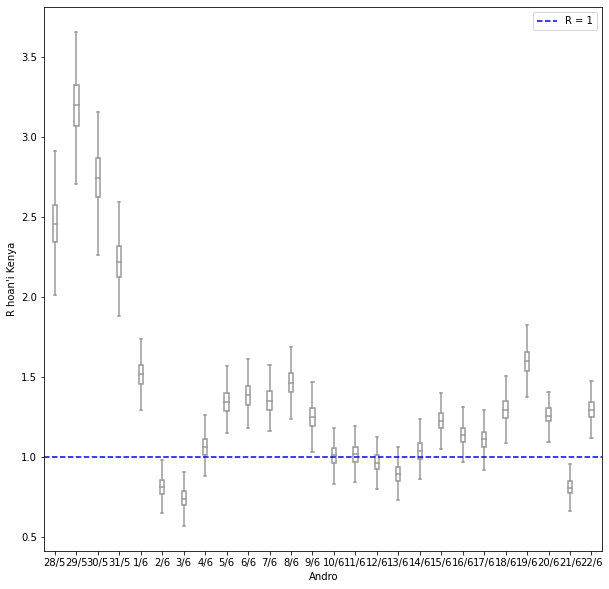

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Kenya")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt205206_ke.eps')
plt.savefig(path_to_save+'Rt205206_ke.png')
plt.show()

In [ ]:
print("Mediana R hoan'ny", daty_lst[17], ':', np.median(data_Rt_lst[17]))

Mediana R hoan'ny 14/6 : 1.0340190177960136


# Jeritodika ny herinandro

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_data_mifarj = datetime.date(2020,6,15)

daty_ambaj = datetime.date(2020,6,13)
daty_amboj = datetime.date(2020,6,9)

daty_vinaj = daty_amboj

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_vinaj)*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_vinaj)*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Plotting the evaluation of the last 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


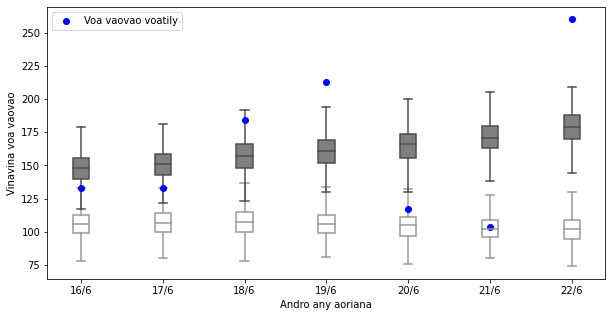

In [ ]:
# Plotting the evaluation of the last 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.2, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.2, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro any aoriana', ylabel="Vinavina voa vaovao")

plt.legend(loc= 'best')

plt.savefig(path_to_save+'Iv166j_ke.eps')
plt.savefig(path_to_save+'Iv166j_ke.png')

plt.show()

# 7 andro manaraka

In [ ]:
daty_amba = datetime.date(2020,6,21)
daty_ambo = datetime.date(2020,6,19)

In [ ]:
# Computing Ivao(daty_mifar + i) for i in range(1,8)


daty_vina = daty_ambo

daty_m1 = daty_data_mifar + datetime.timedelta(days = 1)

Iv = int(Rt_salan(daty_vina)*lsi(daty_m1))

dIvao.loc[pd.to_datetime(daty_m1)] =[Iv]

for i in range(1,8):
 errt = daty_m1 + datetime.timedelta(days = i)
 Ivv = int(Rt_salan(daty_vina)*lsi(errt))
 dIvao.loc[pd.to_datetime(errt)] =[Ivv]


In [ ]:
# Plotting boundaries for the next 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_hoav_lst = []

data_hoav = []

Ivv_dat = []

for i in range(1,8):
  t = daty_data_mifar + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_hoav_lst.append(daty)
  data_hoav.append(data_amboar)


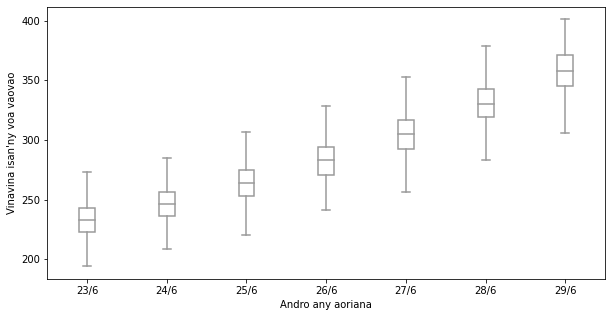

In [ ]:
# Plotting boundaries for the next 7 days

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_hoav_lst, data_hoav, color='white', width=0.2, showfliers=False, ax=ax)

ax.set_xlabel('Andro any aoriana')
ax.set_ylabel("Vinavina isan'ny voa vaovao")

plt.savefig(path_to_save+'Ivbo226hoav_ke.eps')
plt.savefig(path_to_save+'Ivbo226hoav_ke.png')

plt.show()

## DRC Congo

In [ ]:
# Voa vaovao (observed incidence)
Ivao = datawcod['cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,5,20)
daty_data_mifar = datetime.date(2020,6,22)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15)), (inf, datetime.date(2020, 6, 14)), (inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 2)), (inf, datetime.date(2020, 6, 1)), (inf, datetime.date(2020, 5, 31)), (inf, datetime.date(2020, 5, 30)), (inf, datetime.date(2020, 5, 29)), (inf, datetime.date(2020, 5, 28))]
Prt91 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


APEk1 = [2741.7147049245723, 7657.689621247573, 13667.314278980364, inf, inf, inf, inf]
APEk2 = [9.17948770721216, 51.210951509265286, 153.8512886387055, 359.7001808979304, 1104.1402528193116, 1524.762774533684, inf]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [2750.8941926317843, 7708.900572756838, 13821.16556761907, inf, inf, inf, inf]
APE = [2750.8941926317843, 7708.900572756838, 13821.16556761907, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [ ]:

  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


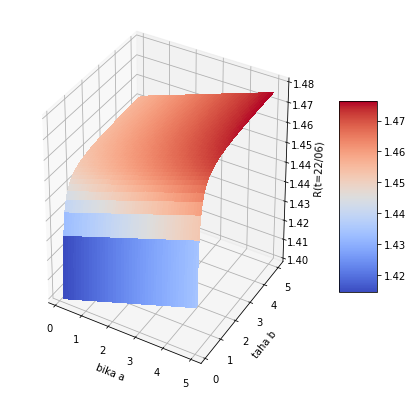

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.4,1.48)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=22/06)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt205226_drc.eps')

plt.show()

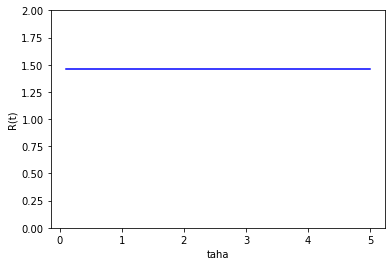

taha* = 1
R(t= 2020-06-22 ) = 1.456748278383929 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-06-14 : 0.6829108474195255
Salan'isa R hoan'ny 2020-06-08 : 1.0047289020057888
Kartily @ 75% R hoan'ny 2020-06-08 : 1.0465819381379342
Kartily @ 25% R hoan'ny 2020-06-08 : 0.9614333055436355
Salan'isa R hoan'ny 2020-06-14 : 0.8202446694038187
Kartily @ 75% R hoan'ny 2020-06-14 : 0.8576955732515306
Kartily @ 25% R hoan'ny 2020-06-14 : 0.7813737887702457


In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


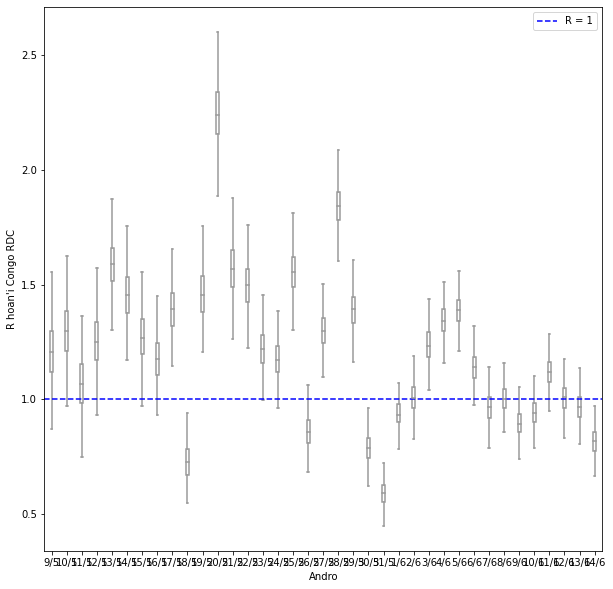

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Congo RDC")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt15146_drc.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


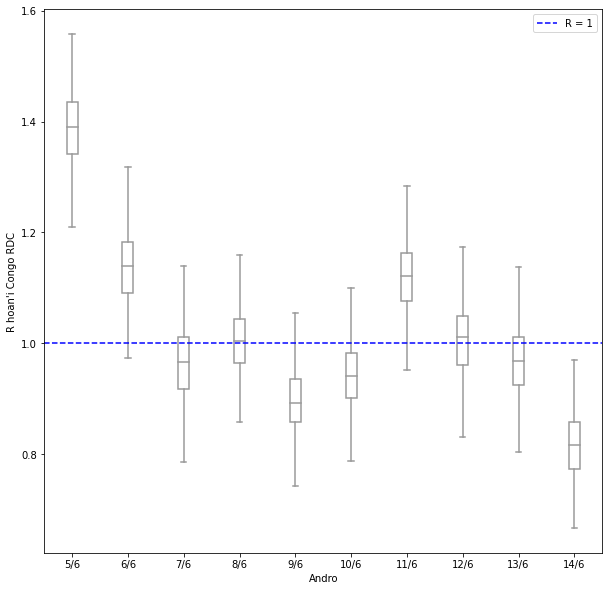

In [ ]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Congo RDC")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_drc.eps')
plt.show()

# South Africa

In [ ]:
# Voa vaovao (observed incidence)
Ivao = datawsa['cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,4,15)
daty_data_mifar = datetime.date(2020,7,4)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (inf, datetime.date(2020, 6, 26)), (inf, datetime.date(2020, 6, 25)), (inf, datetime.date(2020, 6, 24)), (inf, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15)), (inf, datetime.date(2020, 6, 14)), (inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


APEk1 = [inf, inf, inf, inf, inf, inf, inf]
APEk2 = [3.601383231334836, 15.78037787687154, 83.15933183425497, 471.91117341107724, 1051.7514125014295, inf, inf]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [inf, inf, inf, inf, inf, inf, inf]
APE = [inf, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [ ]:
kk = 2
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


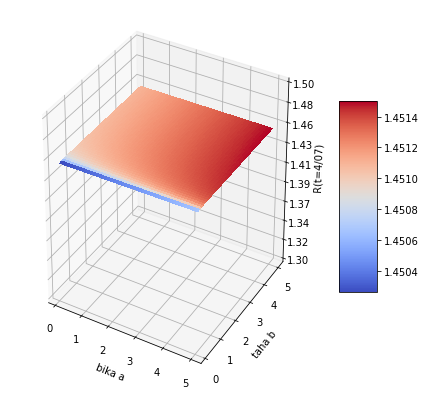

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(1.3, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=4/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15447_sa.eps')

plt.show()

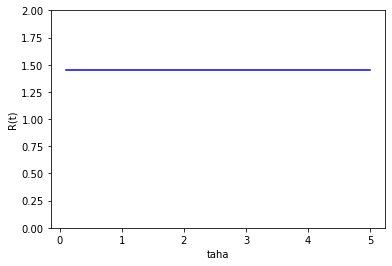

taha* = 1
R(t= 2020-07-04 ) = 1.451116911430104 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-07-04 : 1.441834821679358
Salan'isa R hoan'ny 2020-06-08 : 1.3474969317593573
Kartily @ 75% R hoan'ny 2020-06-08 : 1.3604934873062502
Kartily @ 25% R hoan'ny 2020-06-08 : 1.3343994718381496
Salan'isa R hoan'ny 2020-07-04 : 1.4511169089316978
Kartily @ 75% R hoan'ny 2020-07-04 : 1.4584397084644067
Kartily @ 25% R hoan'ny 2020-07-04 : 1.4437644613668648


In [ ]:
rt_sa_lst = []

for i in range(60):
  t = datetime.date(2020,6,30) - datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  rt_sa_lst.append((t,Rt_salan(t)))

rt_sa_lst

[(datetime.date(2020, 6, 30), array(1.22989978)),
 (datetime.date(2020, 6, 29), array(1.42522593)),
 (datetime.date(2020, 6, 28), array(1.50700596)),
 (datetime.date(2020, 6, 27), array(1.52287123)),
 (datetime.date(2020, 6, 26), array(1.53271132)),
 (datetime.date(2020, 6, 25), array(1.32551891)),
 (datetime.date(2020, 6, 24), array(1.18837697)),
 (datetime.date(2020, 6, 23), array(1.25369127)),
 (datetime.date(2020, 6, 22), array(1.40340481)),
 (datetime.date(2020, 6, 21), array(1.32729719)),
 (datetime.date(2020, 6, 20), array(1.13350695)),
 (datetime.date(2020, 6, 19), array(1.21226833)),
 (datetime.date(2020, 6, 18), array(1.14961442)),
 (datetime.date(2020, 6, 17), array(1.11194361)),
 (datetime.date(2020, 6, 16), array(1.47452245)),
 (datetime.date(2020, 6, 15), array(1.63461824)),
 (datetime.date(2020, 6, 14), array(1.51691704)),
 (datetime.date(2020, 6, 13), array(1.42643367)),
 (datetime.date(2020, 6, 12), array(1.25604438)),
 (datetime.date(2020, 6, 11), array(1.05415633)),


In [ ]:
# MRC Model 2 estimation

r_sa286 = 1.2
r_sa216 = 1.04
r_sa146 = 1.3
r_sa076 = 1.3
r_sa315 = 1.4
r_sa245 = 1.8
r_sa175 = 1.3
r_sa105 = 1.5
r_sa035 = 1.4

In [ ]:
elan_sa286 = r_sa286 - rt_sa_lst[2][1]
elan_sa216 = r_sa216 - rt_sa_lst[9][1]
elan_sa146 = r_sa146 - rt_sa_lst[16][1]
elan_sa076 = r_sa076 - rt_sa_lst[23][1]
elan_sa315 = r_sa315 - rt_sa_lst[30][1]
elan_sa245 = r_sa245 - rt_sa_lst[37][1]
elan_sa175 = r_sa175 - rt_sa_lst[44][1]
elan_sa105 = r_sa105 - rt_sa_lst[51][1]
elan_sa035 = r_sa035 - rt_sa_lst[58][1]
print('286', elan_sa286, rt_sa_lst[2][0])
print('216', elan_sa216, rt_sa_lst[9][0])
print('146', elan_sa146, rt_sa_lst[16][0])
print('076', elan_sa076, rt_sa_lst[23][0])
print(elan_sa315)
print(elan_sa245)
print(elan_sa175)
print(elan_sa105)
print(elan_sa035) 

286 -0.3070059619406751 2020-06-28
216 -0.2872971872594836 2020-06-21
146 -0.2169170411750334 2020-06-14
076 -0.26378540632982506 2020-06-07
-0.23342587609736043
0.4664100891369287
-0.13866283605052376
-0.2278259697163858
-0.13739798889167587


In [ ]:
rt_sa_lst[37]

(datetime.date(2020, 5, 24), array(1.33358991))

In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


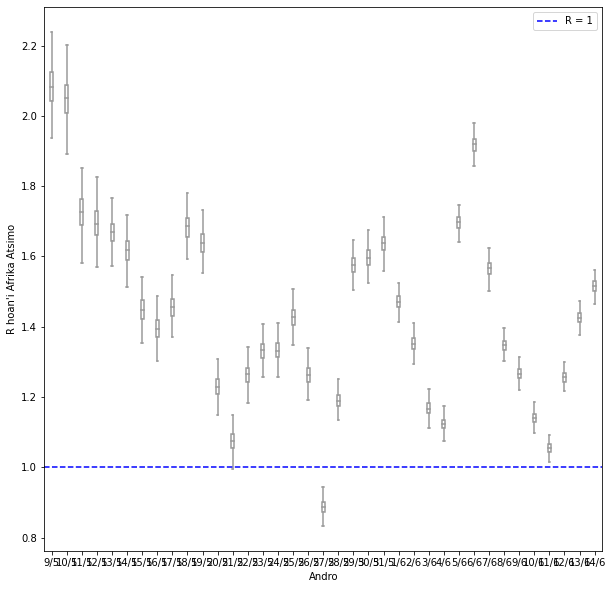

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Afrika Atsimo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt15146_sa.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


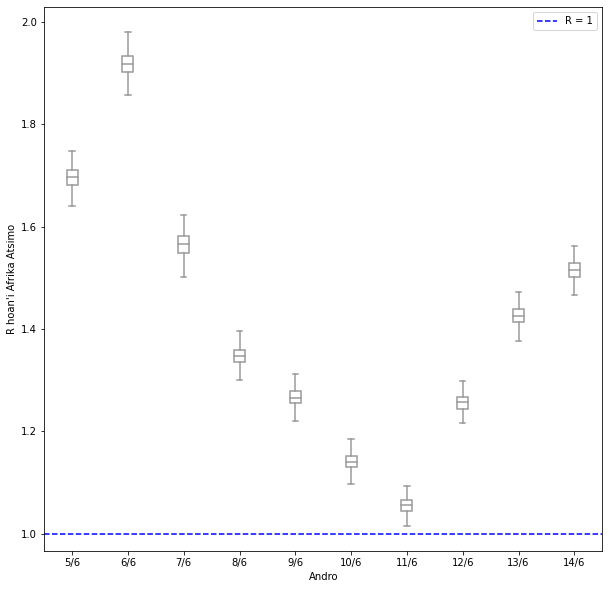

In [ ]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Afrika Atsimo")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_sa.eps')
plt.show()

# Egypt

In [ ]:
# Voa vaovao (observed incidence)
Ivao = dataweg['cases']

dIvao = pd.DataFrame(data =Ivao)

dIvao.sort_index(inplace=True)

# ireo daty fanombohana sy fiafaran'ny antontan'isa raisina
# (Time range of data used for the estimation)

daty_data_manom = datetime.date(2020,4,15)
daty_data_mifar = datetime.date(2020,7,4)

datyt = daty_data_mifar

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# 0/ Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Jereo Imperial Covid-19 COVID-19 response team: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0)
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1,(t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1,k):
      Ivaosi = Ivaosi + dIvao['cases'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)

# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['cases'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

APEt91 = []
Prt91 = []

APE91 = 0

for i in range((daty_data_mifar - daty_data_manom).days - 9 + 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = 9
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

APEt92 = []
Prt92 = []

APE92 = 0
for i in range(7):
  t = daty_data_manom - datetime.timedelta(days = i -7)
  k = 9 - 1 - i
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k),t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, we have :
# lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0,
# so that pnb(t_man + 1, 2) = 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


For k = 9, APE91 = inf
APEt91 = [(inf, datetime.date(2020, 6, 29)), (inf, datetime.date(2020, 6, 28)), (inf, datetime.date(2020, 6, 27)), (inf, datetime.date(2020, 6, 26)), (inf, datetime.date(2020, 6, 25)), (inf, datetime.date(2020, 6, 24)), (inf, datetime.date(2020, 6, 23)), (inf, datetime.date(2020, 6, 22)), (inf, datetime.date(2020, 6, 21)), (inf, datetime.date(2020, 6, 20)), (inf, datetime.date(2020, 6, 19)), (inf, datetime.date(2020, 6, 18)), (inf, datetime.date(2020, 6, 17)), (inf, datetime.date(2020, 6, 16)), (inf, datetime.date(2020, 6, 15)), (inf, datetime.date(2020, 6, 14)), (inf, datetime.date(2020, 6, 13)), (inf, datetime.date(2020, 6, 12)), (inf, datetime.date(2020, 6, 11)), (inf, datetime.date(2020, 6, 10)), (inf, datetime.date(2020, 6, 9)), (inf, datetime.date(2020, 6, 8)), (inf, datetime.date(2020, 6, 7)), (inf, datetime.date(2020, 6, 6)), (inf, datetime.date(2020, 6, 5)), (inf, datetime.date(2020, 6, 4)), (inf, datetime.date(2020, 6, 3)), (inf, datetime.date(2020, 6, 

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in log


APEk1 = [inf, inf, inf, inf, inf, inf, inf]
APEk2 = [13.483346208446335, 48.35427128138335, 210.4041019607534, 708.3585378179562, 1347.0338923523666, inf, inf]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = inf
APEk = [inf, inf, inf, inf, inf, inf, inf]
APE = [inf, inf, inf, inf, inf, inf, inf, inf]
2


## Fifidianana ireo taha mialoha (prior parameters)

In [ ]:
kk = 2
  #shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh
  # Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc

def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[0.01, 1e+11])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


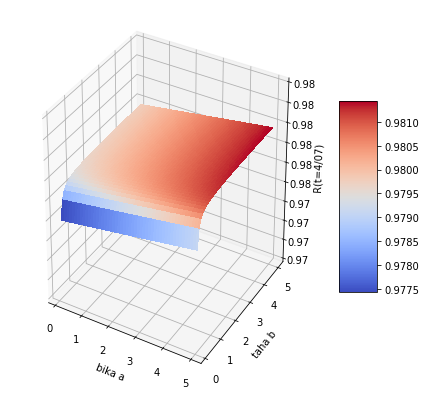

In [ ]:
# Variation of R(datyab) with rapport to the prior parameters

datyab = daty_data_mifar

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')

# Make data.
X = np.linspace(0.1,5,100)
Y = np.linspace(0.1,5,100)
X, Y = np.meshgrid(X, Y)
Z = func_sh(datyab)(X)*func_sc(datyab)(Y)
W = X*Y
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#surf = ax.plot_surface(X, Y, W, cmap=cm.coolwarm,
 #                      linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0.97, 0.985)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set(xlabel ='bika a', ylabel = "taha b", zlabel = 'R(t=4/07)')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.savefig(path_to_save+'Rt15447_eg.eps')

plt.show()

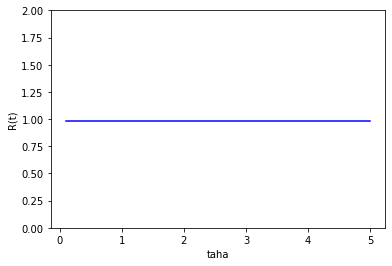

taha* = 1
R(t= 2020-07-04 ) = 0.979809532775691 = bika*


In [ ]:
# R(t) when equality between the prior and the posterior

# 100 linearly spaced numbers
x = np.linspace(0.1,5,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x, x*funcsh_inv(datyab)(x/func_sc(datyab)(x)), 'blue')

ax.set_ylim(0,2)
ax.set(xlabel ='taha', ylabel = "R(t)")


# show the plot
plt.show()

print('taha* = 1')
print('R(t=',datyab,') =', funcsh_inv(datyab)(1/func_sc(datyab)(1)), '= bika*')


## Fanombanana ny Rt

In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))


def Rtps_sal(t):
  return dIvao['cases'].loc[format_date(t)]/lsi(t)

print("Kajy mivantana ny R hoan'ny", daty_data_mifar, ':', Rtps_sal(daty_data_mifar))

daty_oh1 = datetime.date(2020,6,8)
print("Salan'isa R hoan'ny", daty_oh1, ':', Rt_salan(daty_oh1))
print("Kartily @ 75% R hoan'ny", daty_oh1, ':', perc75(daty_oh1))
print("Kartily @ 25% R hoan'ny", daty_oh1, ':', perc25(daty_oh1))

print("Salan'isa R hoan'ny", daty_data_mifar, ':', Rt_salan(daty_data_mifar))
print("Kartily @ 75% R hoan'ny", daty_data_mifar, ':', perc75(daty_data_mifar))
print("Kartily @ 25% R hoan'ny", daty_data_mifar, ':', perc25(daty_data_mifar))


Kajy mivantana ny R hoan'ny 2020-07-04 : 0.9538366091241247
Salan'isa R hoan'ny 2020-06-08 : 1.2426486322076506
Kartily @ 75% R hoan'ny 2020-06-08 : 1.2579635008510546
Kartily @ 25% R hoan'ny 2020-06-08 : 1.2271814926821722
Salan'isa R hoan'ny 2020-07-04 : 0.9798095325932107
Kartily @ 75% R hoan'ny 2020-07-04 : 0.9920236879542753
Kartily @ 25% R hoan'ny 2020-07-04 : 0.9674725240417364


In [ ]:
rt_eg_lst = []

for i in range(60):
  t = datetime.date(2020,6,30) - datetime.timedelta(days = i)
  rt_amboar = Rt_salan(t)
  rt_eg_lst.append((t,Rt_salan(t)))

rt_eg_lst

[(datetime.date(2020, 6, 30), array(0.95907206)),
 (datetime.date(2020, 6, 29), array(0.82960961)),
 (datetime.date(2020, 6, 28), array(0.9650651)),
 (datetime.date(2020, 6, 27), array(1.59650381)),
 (datetime.date(2020, 6, 26), array(1.00656243)),
 (datetime.date(2020, 6, 25), array(0.43858601)),
 (datetime.date(2020, 6, 24), array(0.95722256)),
 (datetime.date(2020, 6, 23), array(1.00608486)),
 (datetime.date(2020, 6, 22), array(0.99787128)),
 (datetime.date(2020, 6, 21), array(1.09624687)),
 (datetime.date(2020, 6, 20), array(0.98496693)),
 (datetime.date(2020, 6, 19), array(0.85283532)),
 (datetime.date(2020, 6, 18), array(0.9839736)),
 (datetime.date(2020, 6, 17), array(1.12007042)),
 (datetime.date(2020, 6, 16), array(1.16645626)),
 (datetime.date(2020, 6, 15), array(1.18915408)),
 (datetime.date(2020, 6, 14), array(1.19932665)),
 (datetime.date(2020, 6, 13), array(1.1329842)),
 (datetime.date(2020, 6, 12), array(1.10653335)),
 (datetime.date(2020, 6, 11), array(1.10689362)),
 (d

In [ ]:
r_eg286 = 1.3
r_eg216 = 1.3
r_eg146 = 1.1
r_eg076 = 1
r_eg315 = 1.2
r_eg245 = 1.2
r_eg175 = 1.4
r_eg105 = 1.4
r_eg035 = 0.9

In [ ]:
elan_eg286 = r_eg286 - rt_eg_lst[2][1]
elan_eg216 = r_eg216 - rt_eg_lst[9][1]
elan_eg146 = r_eg146 - rt_eg_lst[16][1]
elan_eg076 = r_eg076 - rt_eg_lst[23][1]
elan_eg315 = r_eg315 - rt_eg_lst[30][1]
elan_eg245 = r_eg245 - rt_eg_lst[37][1]
elan_eg175 = r_eg175 - rt_eg_lst[44][1]
elan_eg105 = r_eg105 - rt_eg_lst[51][1]
elan_eg035 = r_eg035 - rt_eg_lst[58][1]
print('286', elan_eg286, rt_eg_lst[2][0])
print('216', elan_eg216, rt_eg_lst[9][0])
print('146', elan_eg146, rt_eg_lst[16][0])
print('076', elan_eg076, rt_eg_lst[23][0])
print(elan_eg315)
print(elan_eg245)
print(elan_eg175)
print(elan_eg105)
print(elan_eg035) 

286 0.3349348990373656 2020-06-28
216 0.20375313068263612 2020-06-21
146 -0.09932665497547455 2020-06-14
076 -0.2151090860686864 2020-06-07
-0.5440450504464012
-0.3108404151821287
0.25362113784754325
-0.13673985315213333
-0.5458714556064282


In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(400)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


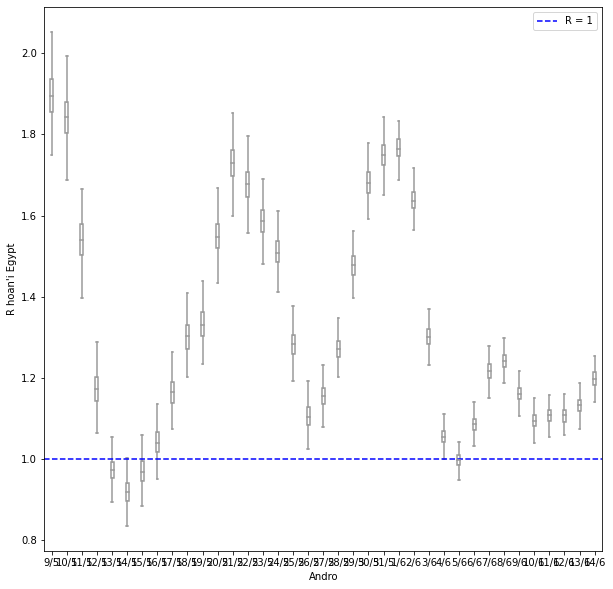

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Egypt")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt154306_eg.eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


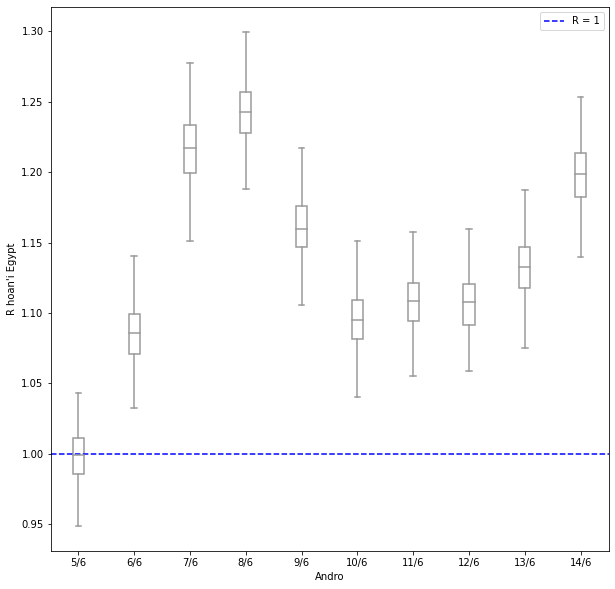

In [ ]:
# Plotting the last 10 days before daty_data_mifar


fig, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(daty_lst[len(daty_lst)-10:len(daty_lst)], data_Rt_lst[len(daty_lst)-10:len(daty_lst)], color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Egypt")
ax.legend(loc= 'best')


plt.savefig(path_to_save+'Rt1514610_eg.eps')
plt.show()